In [39]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
import pandas as pd

from scipy.optimize import minimize

import src.src_adiabatic_ramp
import src.src_current_measurement_simulations

import importlib

importlib.reload(src.src_adiabatic_ramp);
importlib.reload(src.src_current_measurement_simulations);

from src.src_adiabatic_ramp import AdiabaticRampGainMeasurement, generate_ramp_filename
from src.src_current_measurement_simulations import CurrentMeasurementSimulation

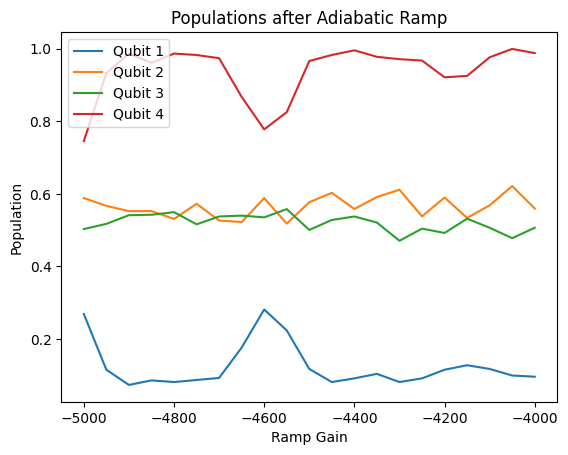

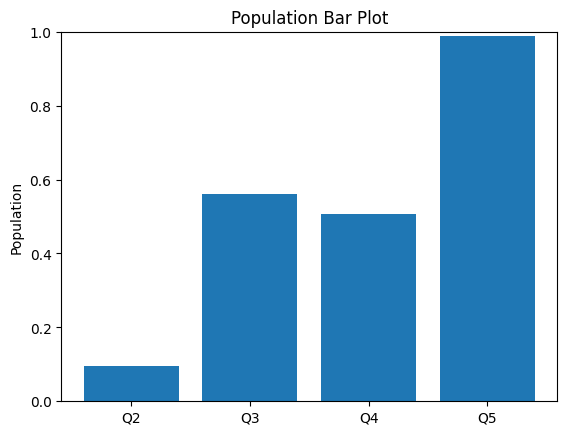

In [40]:
test_filename = generate_ramp_filename('2025', '07', '27', '13', '29', '44')

ramp_measurement = AdiabaticRampGainMeasurement(test_filename)

population = ramp_measurement.plot_populations(corrected=True)
ramp_measurement.plot_population_bar_plot(corrected=True, gain_index=-1)


# 1. Fit Populations

### 1.1 Load in data

CD


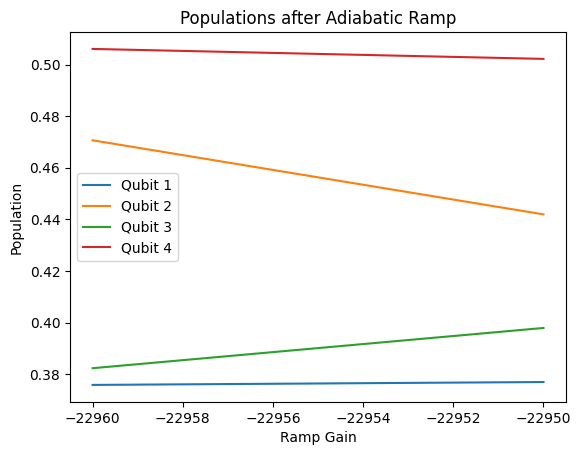

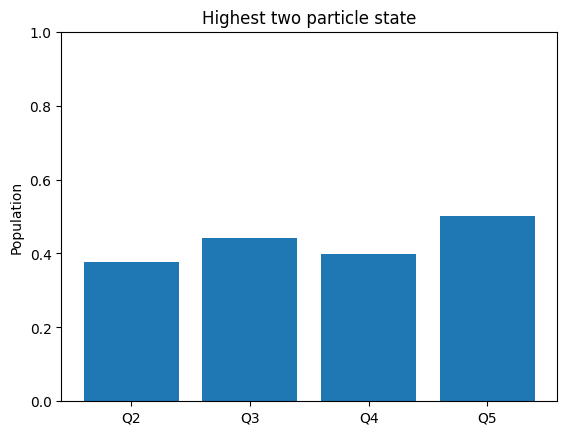

BD


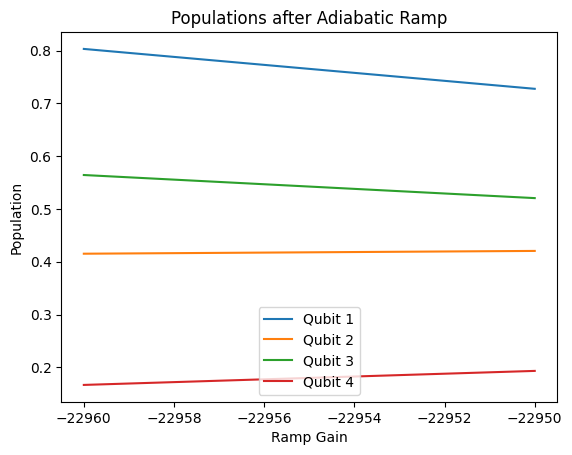

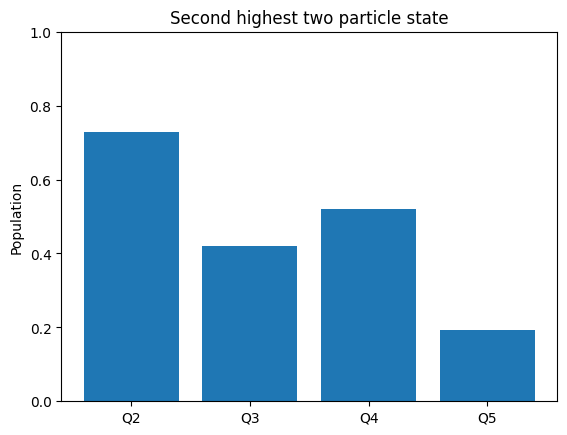

BC


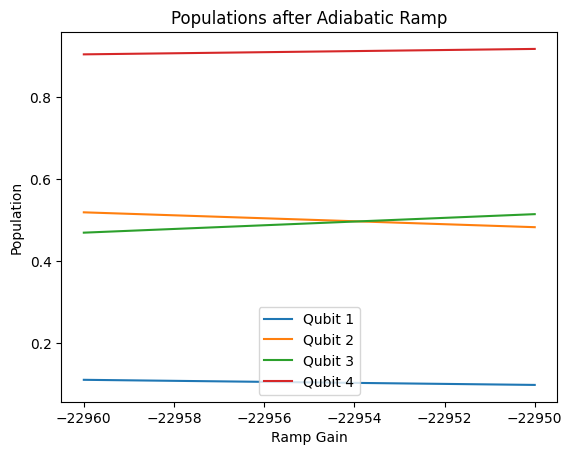

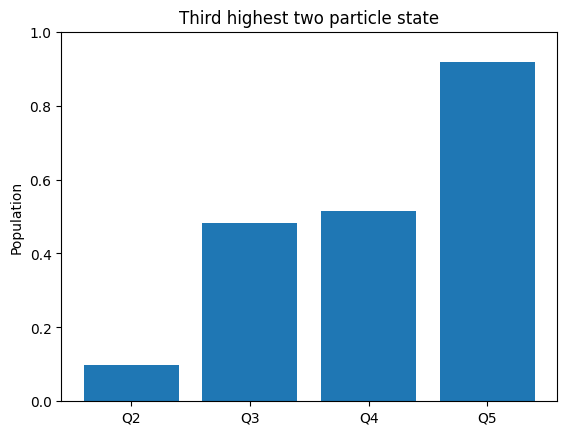

D


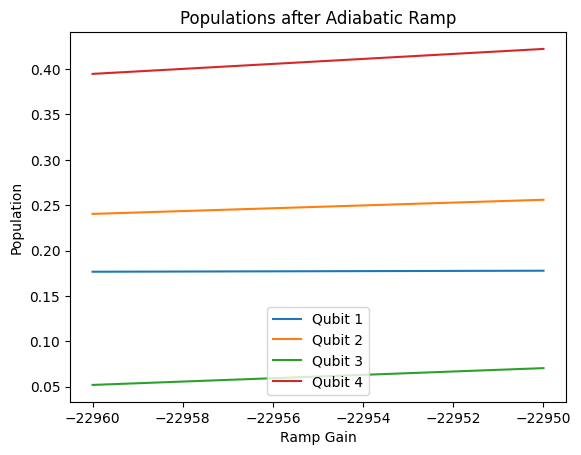

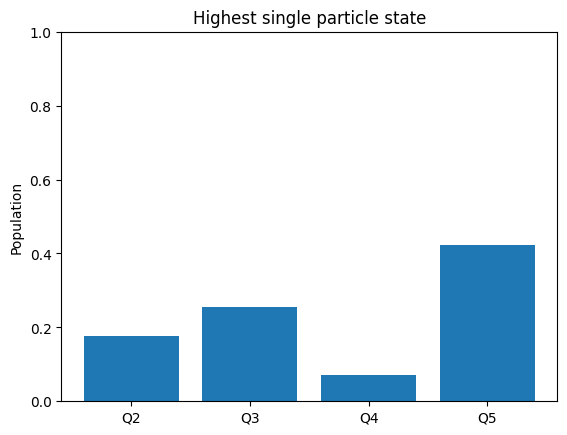

C


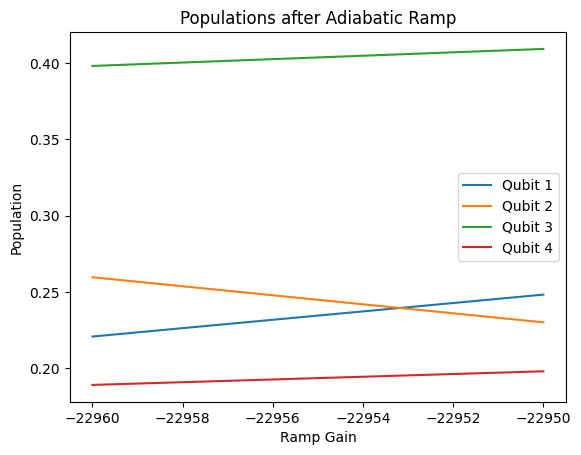

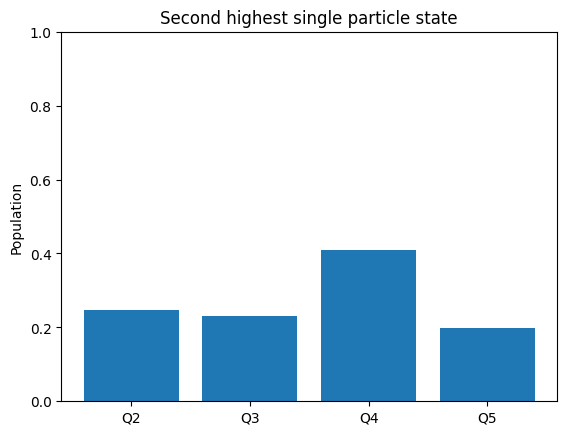

B


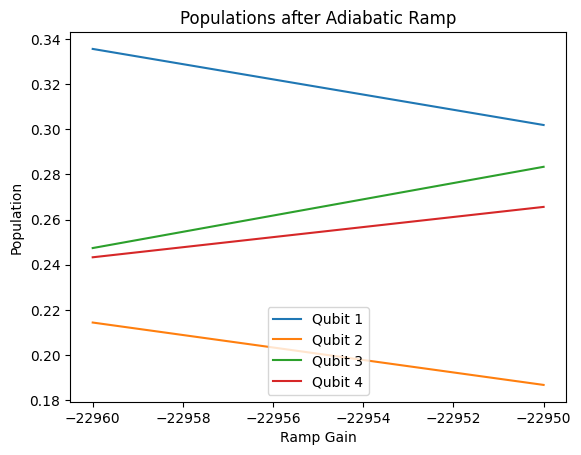

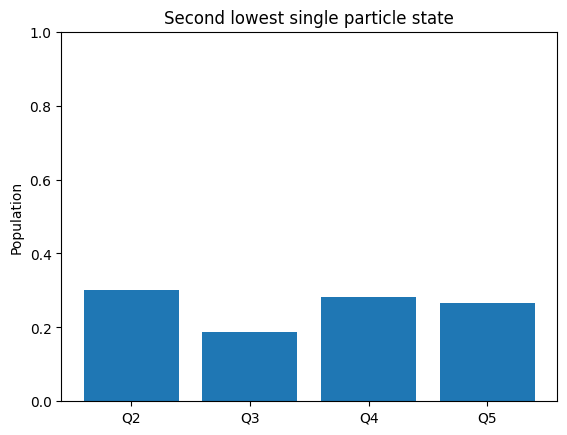

A


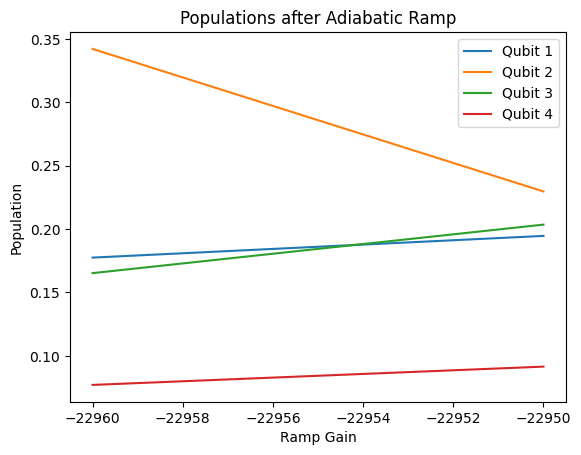

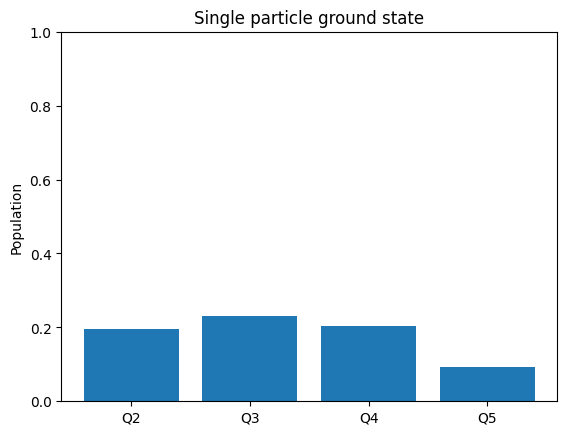

In [45]:

state_to_filename = {}
state_to_measurement = {}
state_to_popualation_data = {}

# sweep Q1
state_to_filename['CD'] = generate_ramp_filename('2025', '07', '28', '09', '42', '20')
state_to_filename['BD'] = generate_ramp_filename('2025', '07', '28', '09', '43', '25')
state_to_filename['BC'] = generate_ramp_filename('2025', '07', '28', '09', '44', '02')
state_to_filename['D'] = generate_ramp_filename('2025', '07', '28', '09', '44', '51')

# sweep Q2
state_to_filename['CD'] = generate_ramp_filename('2025', '07', '28', '10', '03', '13')
state_to_filename['BD'] = generate_ramp_filename('2025', '07', '28', '10', '03', '56')
state_to_filename['BC'] = generate_ramp_filename('2025', '07', '28', '10', '04', '35')
state_to_filename['D'] = generate_ramp_filename('2025', '07', '28', '10', '05', '19')

# sweep Q3
state_to_filename['CD'] = generate_ramp_filename('2025', '07', '28', '10', '17', '00')
state_to_filename['BD'] = generate_ramp_filename('2025', '07', '28', '10', '17', '43')
state_to_filename['BC'] = generate_ramp_filename('2025', '07', '28', '10', '18', '23')
state_to_filename['D'] = generate_ramp_filename('2025', '07', '28', '10', '19', '00')

# sweep Q4
# state_to_filename['CD'] = generate_ramp_filename('2025', '07', '27', '15', '17', '03')
# state_to_filename['BD'] = generate_ramp_filename('2025', '07', '27', '15', '17', '54')
# state_to_filename['BC'] = generate_ramp_filename('2025', '07', '27', '13', '29', '44')
# state_to_filename['D'] = generate_ramp_filename('2025', '07', '27', '15', '21', '12')


# final
state_to_filename['CD'] = generate_ramp_filename('2025', '07', '28', '10', '39', '38')
state_to_filename['BD'] = generate_ramp_filename('2025', '07', '28', '10', '40', '18')
state_to_filename['BC'] = generate_ramp_filename('2025', '07', '28', '10', '40', '47')
state_to_filename['D'] = generate_ramp_filename('2025', '07', '28', '10', '41', '19')
state_to_filename['C'] = generate_ramp_filename('2025', '07', '28', '10', '44', '20')
state_to_filename['B'] = generate_ramp_filename('2025', '07', '28', '10', '45', '00')
state_to_filename['A'] = generate_ramp_filename('2025', '07', '28', '10', '45', '38')

state_to_title = {}
state_to_title['CD'] = 'Highest two particle state'
state_to_title['BD'] = 'Second highest two particle state'
state_to_title['BC'] = 'Third highest two particle state'
state_to_title['A'] = 'Single particle ground state'
state_to_title['B'] = 'Second lowest single particle state'
state_to_title['C'] = 'Second highest single particle state'
state_to_title['D'] = 'Highest single particle state'

for state in state_to_filename:
    print(state)
    state_to_measurement[state] = AdiabaticRampGainMeasurement(state_to_filename[state])
    state_to_popualation_data[state] = state_to_measurement[state].get_population_corrected()
    state_to_measurement[state].plot_populations(corrected=True)

    state_to_measurement[state].plot_population_bar_plot(corrected=True, gain_index=-1, title=state_to_title[state])



# assume all have the same gain sweep
gains = state_to_measurement['CD'].get_ff_gains()







### 1.2 Fit to Hamiltonian

In [44]:
def cost_function(data, simulation):
    """
    Calculate the cost function as the sum of squared differences between data and simulation.
    """
    return np.sum((data - simulation) ** 2)

In [22]:
def create_psi0_with_angles(psi0, current_measurement_simulation, num_levels, num_qubits, num_particles, angles, bitstring):
    """
    Create a psi0 string with given angles and bitstring.
    If bitstring is None, it will be generated based on num_particles.
    """

    if bitstring is not None:

        if len(bitstring) != num_qubits:
            raise ValueError(f"psi0_bitstring must have length {num_qubits}, got {len(bitstring)}.")
        if bitstring.count('1') != num_particles:
            raise ValueError(f"psi0_bitstring must have exactly {num_particles} '1's, got {bitstring.count('1')}.")

        if isinstance(psi0, int):
            eigenstate_index = psi0
            one_particle_eigenstates = current_measurement_simulation.get_particle_number_to_eigenstate_dict()[1]
            two_particle_eigenstates = current_measurement_simulation.get_particle_number_to_eigenstate_dict()[2]

            # try prepare |0001> but actually get |0>|0>|theta_1, phi_1>|theta_2, phi_2>
            # |theta_i, phi_i> = cos(theta_i/2) |0> + exp(i*phi_i) sin(theta_i/2) |1>

            # |0000> -> vacuum state
            # |0001> -> current_measurement_simulation.get_particle_number_to_eigenstate()[1][-1]
            # |0010> -> current_measurement_simulation.get_particle_number_to_eigenstate()[1][-2]
            # |0011> -> current_measurement_simulation.get_particle_number_to_eigenstate()[2][-1]

            theta_1, phi_1, theta_2, phi_2 = angles

            

            prepared_state = 0

            if num_particles == 2:

                # find indices of two 1's in psi0_bitstring
                indices = [i for i in range(len(bitstring)) if bitstring[i] == '1']

                index_1, index_2 = indices
                negative_index_1 = -(num_qubits - index_1)
                negative_index_2 = -(num_qubits - index_2)


                prepared_state += np.cos(theta_1/2)*np.cos(theta_2/2) * qt.basis([num_levels] * num_qubits, [0, 0, 0, 0])  # |0000> 
                prepared_state += np.cos(theta_1/2)*np.sin(theta_2/2) * np.exp(1j*phi_2) * one_particle_eigenstates[negative_index_1]  # |0001> 
                prepared_state += np.sin(theta_1/2)*np.cos(theta_2/2) * np.exp(1j*phi_1) * one_particle_eigenstates[negative_index_2]  # |0010> 
                prepared_state += np.sin(theta_1/2)*np.sin(theta_2/2) * np.exp(1j*(phi_1 + phi_2)) * two_particle_eigenstates[eigenstate_index]  # |0011> 

                # print(f'first single particle state index: {negative_index_2}')
                # print(f'second single particle state index: {negative_index_1}')
                # print(f'two particle state index: {eigenstate_index}')

            else:
                eigenstate_index = psi0
                one_particle_eigenstates = current_measurement_simulation.get_particle_number_to_eigenstate_dict()[1]
                two_particle_eigenstates = current_measurement_simulation.get_particle_number_to_eigenstate_dict()[2]

                # try prepare |0001> but actually get |0>|0>|0>|theta, phi>
                # |theta_i, phi_i> = cos(theta_i/2) |0> + exp(i*phi_i) sin(theta_i/2) |1>

                # |0000> -> vacuum state
                # |0001> -> current_measurement_simulation.get_particle_number_to_eigenstate()[1][-1]

                theta, phi, _, _ = angles

                prepared_state = 0
                prepared_state += np.cos(theta/2) * qt.basis([num_levels] * num_qubits, [0, 0, 0, 0])  # |0000> 
                prepared_state += np.sin(theta/2) * np.exp(1j*phi) * one_particle_eigenstates[eigenstate_index]  # |0001> 


        else:
            raise ValueError("psi0 must be an integer index if psi0_angles is provided.")
    else:
        raise ValueError("If psi0_angles is provided, psi0_bitstring must also be provided.")
    
    return prepared_state

In [23]:
def calculate_population_simulation(num_levels, num_qubits, num_particles, J, J_parallel, U, initial_detunings, psi0=None, scale_factor=1, psi0_angles=None, psi0_bitstring=None):

    times = np.linspace(0, 1, 2) # dummy

    current_measurement_simulation = CurrentMeasurementSimulation(num_levels, num_qubits, num_particles, J, J_parallel, U, times, 
                                                                  [0,1], [2,3], initial_detunings, 
                                                                  measurement_detuning=None, measurement_J=None, 
                                                                  measurement_J_parallel=None, 
                                                                  psi0=psi0, time_offset=0)
    
    if psi0_angles is not None:
        current_measurement_simulation.psi0 = create_psi0_with_angles(psi0, current_measurement_simulation, num_levels, num_qubits, num_particles, psi0_angles, psi0_bitstring)

    
    ramp_populations = np.zeros(num_qubits)

    number_operators = current_measurement_simulation.number_operators
    for i in range(len(ramp_populations)):
        ramp_populations[i] = qt.expect(number_operators[i], current_measurement_simulation.psi0)

    return ramp_populations * scale_factor


def calculate_population_simulation_all_states(num_levels, num_qubits, all_num_particles, J, J_parallel, U, initial_detunings, all_psi0, scale_factor=1, psi0_angles=None, psi0_bitstring=None,
                                               num_particles=None, psi0=None, state_strings=None):
    times = np.linspace(0, 1, 2) #

    ramp_populations = np.zeros((len(all_psi0), num_qubits))

    # print(f'calculating for all states: {all_psi0}')

    for i in range(len(all_psi0)):
        psi0 = all_psi0[i]
        num_particles = all_num_particles[i]

        # print(f'creating measurement with psi0: {psi0}, num_particles: {num_particles}')
        # if state_strings is not None:
            # print(f'expected populations: {state_to_popualation_data[state_strings[i]][:, gain_index]}')

        current_measurement_simulation = CurrentMeasurementSimulation(num_levels, num_qubits, num_particles, J, J_parallel, U, times, 
                                                                    [0,1], [2,3], initial_detunings, 
                                                                    measurement_detuning=None, measurement_J=None, 
                                                                    measurement_J_parallel=None, 
                                                                    psi0=psi0, time_offset=0)
        
        
        # if psi0_angles is not None:
        #     current_measurement_simulation.psi0 = create_psi0_with_angles(psi0, current_measurement_simulation, num_levels, num_qubits, num_particles, psi0_angles, psi0_bitstring)

        
        number_operators = current_measurement_simulation.number_operators
        for j in range(ramp_populations.shape[1]):
            ramp_populations[i,j] = qt.expect(number_operators[j], current_measurement_simulation.psi0)

    return ramp_populations * scale_factor


In [24]:
state = 'BC'
gain_index = -1

population_data = state_to_popualation_data[state][:, gain_index]


num_levels = 3
num_qubits = 4



# 0 flux
J = -np.array([6.74, 5.9, 5.79]) * 2 * np.pi # MHz
J_parallel = np.array([5.1, 5.38]) * 2 * np.pi # MHz
initial_detunings = np.array([0, 0, 0, 0]) * 2 * np.pi # MHz

# pi flux
J = -np.array([6.26, 5.9, 5.95]) * 2 * np.pi # MHz
J_parallel = -np.array([7.25, 7.65]) * 2 * np.pi # MHz
initial_detunings = np.array([0, 0, 0, 0]) * 2 * np.pi # MHz

psi0_angles = [np.pi]*4
scale_factor = 1.0

# psi0_angles = None


U = -180 * 2 * np.pi

initial_detunings = [2.415910794953103, 0.5700512866261311, -1.301588850183338, -1.6763688301887019]


# psi0 = 'highest_single_particle'
if state == 'CD':
    psi0 = -1
    num_particles = 2
    psi0_bitstring = '0011'
elif state == 'BD':
    psi0 = -2
    num_particles = 2
    psi0_bitstring = '0101'
elif state == 'BC':
    psi0 = -3
    num_particles = 2
    psi0_bitstring = '0110'
    
    # initial_detunings = [28.40747969144447, -27.90547555388191, -34.46937255178215, 34.198716236570874]
elif state == 'D':
    psi0 = -1
    num_particles = 1
    psi0_bitstring = '0001'

population_simulation = calculate_population_simulation(num_levels, num_qubits, num_particles, J, J_parallel, U, 
                                                        initial_detunings, psi0=psi0, scale_factor=scale_factor,
                                                          psi0_angles=psi0_angles, psi0_bitstring=psi0_bitstring)


df_compare = pd.DataFrame({
    'Population Data': population_data,
    'Population Simulation': population_simulation
}, index=[f'Qubit {i+1}' for i in range(4)])

df_compare['Difference'] = df_compare['Population Data'] - df_compare['Population Simulation']
# df_compare['Percent Difference'] = 100 * df_compare['Difference'] / df_compare['Population Data']

print(f'cost: {cost_function(population_data, population_simulation)}')

print(df_compare)

cost: 0.022351219947797468
         Population Data  Population Simulation  Difference
Qubit 1         0.098595               0.173665   -0.075070
Qubit 2         0.483230               0.549425   -0.066194
Qubit 3         0.515004               0.446132    0.068872
Qubit 4         0.917903               0.830778    0.087124


In [25]:
# initial_detunings = [2.415910794953103, 0.5700512866261311, -1.301588850183338, -1.6763688301887019]

simulation_kwargs = dict(
    num_levels=num_levels,
    num_qubits=num_qubits,
    num_particles=num_particles,
    J=J,
    J_parallel=J_parallel,
    U=U,
    initial_detunings=initial_detunings,
    psi0=psi0,
    scale_factor=scale_factor,
    psi0_angles=psi0_angles,
    psi0_bitstring=psi0_bitstring
)

print(f'simulation_kwargs: {simulation_kwargs}')

initial_guess_dict = dict(
    J=J.copy(),
    J_parallel=J_parallel.copy(),
    initial_detunings=initial_detunings.copy(),
    scale_factor=scale_factor,
    psi0_angles=psi0_angles.copy() if psi0_angles is not None else None,
)

J_delta_ratio = 0.8
detuning_bound = 8 * 2 * np.pi  # 5 MHz

bounds_dict = dict(
    J=[(val - np.abs(val) * J_delta_ratio, val + np.abs(val) * J_delta_ratio) for val in J],
    J_parallel=[(val - np.abs(val) * J_delta_ratio, val + np.abs(val) * J_delta_ratio) for val in J_parallel],
    initial_detunings=[(-detuning_bound, detuning_bound) for _ in initial_detunings],
    scale_factor=(0.2, 1),
    psi0_angles=[(0, np.pi) if i in [0, 2] else (0, 2 * np.pi) for i in range(len(psi0_angles))] if psi0_angles is not None else None,
)


def create_objective_function(_fit_params, _simulation_kwargs, _initial_guess_dict, _bounds_dict, fit_states=None, _gain_index=None):


    if fit_states is not None:
        if isinstance(fit_states, str):
            fit_states = [fit_states]
    else:
        fit_states = [state] # define outside

    if _gain_index is None:
        _gain_index = 0

    key_to_indices = {}
    index_counter = 0

    initial_guess_list = []
    bounds_list = []

    for key in _simulation_kwargs:
        if key in _fit_params:
            initial_guess = _initial_guess_dict[key]
            bounds = _bounds_dict[key]

            if isinstance(bounds, list):
                bounds_list.extend(bounds)
            else:
                bounds_list.append(bounds)

            if isinstance(initial_guess, (list, tuple, np.ndarray)):
                initial_guess_list.extend(initial_guess)

                variable_length = len(initial_guess)
                key_to_indices[key] = (index_counter, index_counter + variable_length)
                index_counter += variable_length
            else:
                initial_guess_list.append(initial_guess)

                key_to_indices[key] = (index_counter, index_counter + 1)
                index_counter += 1


    def objective_function(x):
        """
        Objective function to minimize.
        x is a flat array containing all parameters in the order defined by key_to_indices.
        """
        # Extract parameters based on key_to_indices
        params = simulation_kwargs.copy()
        for key, (start, end) in key_to_indices.items():
            params[key] = x[start:end] if end - start > 1 else x[start]

        # Calculate the population data from the simulation
        population_simulation = calculate_population_simulation(**params)

        # Calculate the cost function as the sum squared error between measured and simulated N-terms
        return cost_function(population_data, population_simulation)
    
    def objective_function_all_states(x):
        """
        Objective function to minimize.
        x is a flat array containing all parameters in the order defined by key_to_indices.
        """
        # Extract parameters based on key_to_indices
        params = simulation_kwargs.copy()
        for key, (start, end) in key_to_indices.items():
            params[key] = x[start:end] if end - start > 1 else x[start]

        # params['state_strings'] = fit_states

        params['all_num_particles'] = [state_to_particle_number[state] for state in fit_states]
        params['all_psi0'] = [state_to_index[state] for state in fit_states]

        # Calculate the population data from the simulation
        population_simulation = calculate_population_simulation_all_states(**params)

        # Calculate the cost function as the sum squared error between measured and simulated N-terms
        return cost_function(population_data_all, population_simulation)

    if len(fit_states) > 1:
        population_data_all = np.array([state_to_popualation_data[state][:, _gain_index] for state in fit_states])
        return objective_function_all_states, key_to_indices, initial_guess_list, bounds_list
    else:
        population_data = state_to_popualation_data[fit_states[0]][:, _gain_index]
        return objective_function, key_to_indices, initial_guess_list, bounds_list
        


fit_states = ['CD', 'BD', 'BC', 'D', 'C', 'B', 'A']
# fit_states = ['CD', 'BD', 'BC', 'D']
# fit_states = ['BD', 'BC', 'D', 'C', 'B', 'A']
# fit_states = ['CD']
gain_indices = [-1]
# gain_indices = range(len(gains))

state_to_index = {
    'CD': -1,
    'BD': -2,
    'BC': -3,
    'D': -1,
    'C': -2,
    'B': -3,
    'A': -4,
}

state_to_particle_number = {
    'CD': 2,
    'BD': 2,
    'BC': 2,
    'D': 1,
    'C': 1,
    'B': 1,
    'A': 1,
}

state_to_psi0_bitstring = {
    'CD': '0011',
    'BD': '0101',
    'BC': '0110',
    'D': '0001',
    'C': '0010',
    'B': '0100',
    'A': '1000',
}

gain_index_to_result = {}
gain_index_to_optimal_params = {}
gain_index_to_cost = {}
        
fit_params = ['J', 'J_parallel', 'initial_detunings']
fit_params = ['initial_detunings']
# fit_params = ['initial_detunings', 'psi0_angles', 'scale_factor']

for i in range(len(gain_indices)):
    gain_index = gain_indices[i]
    print(f'Calculating for gain index: {gain_index}')

    objective_function, key_to_indices, initial_guess, bounds = create_objective_function(fit_params, simulation_kwargs, initial_guess_dict, bounds_dict, fit_states=fit_states, _gain_index=gain_index)

    print(objective_function)
    print("Key to Indices:", key_to_indices)
    print("Initial Guess:", initial_guess)
    print("Bounds:", bounds)

    # nad ok
    result = minimize(objective_function, initial_guess, bounds=bounds)
    print("Optimization success:", result.success)
    print("Final cost:", result.fun)

    gain_index_to_optimal_params[gain_index] = {}

    for key in fit_params:
        start, end = key_to_indices[key]
        if end - start > 1:
            gain_index_to_optimal_params[gain_index][key] = list(result.x[start:end])
            print(f"{key} = {list(result.x[start:end])}")
        else:
            gain_index_to_optimal_params[gain_index][key] = result.x[start]
            print(f"{key} = {result.x[start]}")

    gain_index_to_result[gain_index] = result
    gain_index_to_cost[gain_index] = result.fun


simulation_kwargs: {'num_levels': 3, 'num_qubits': 4, 'num_particles': 2, 'J': array([-39.33274002, -37.07079331, -37.38495258]), 'J_parallel': array([-45.55309348, -48.0663676 ]), 'U': -1130.9733552923256, 'initial_detunings': [2.415910794953103, 0.5700512866261311, -1.301588850183338, -1.6763688301887019], 'psi0': -3, 'scale_factor': 1.0, 'psi0_angles': [3.141592653589793, 3.141592653589793, 3.141592653589793, 3.141592653589793], 'psi0_bitstring': '0110'}
Calculating for gain index: -1
<function create_objective_function.<locals>.objective_function_all_states at 0x000001D108EA5E10>
Key to Indices: {'initial_detunings': (0, 4)}
Initial Guess: [2.415910794953103, 0.5700512866261311, -1.301588850183338, -1.6763688301887019]
Bounds: [(-50.26548245743669, 50.26548245743669), (-50.26548245743669, 50.26548245743669), (-50.26548245743669, 50.26548245743669), (-50.26548245743669, 50.26548245743669)]
Optimization success: True
Final cost: 0.2786932011842236
initial_detunings = [18.184436819350

In [26]:
for i in range(len(gain_indices)):
    gain_index = gain_indices[i]
    result = gain_index_to_result[gain_index]

    print(f'cost: {result.fun}\n')

    for key in fit_params:
        start, end = key_to_indices[key]
        if end - start > 1:
            print(f"{key} = {list(result.x[start:end])}")
        else:
            print(f"{key} = {result.x[start]}")


    print()
    print(f'MHz:')
    for key in fit_params:
        factor = 1
        if key in ['J', 'J_parallel', 'initial_detunings']:
            factor = 2 * np.pi
        start, end = key_to_indices[key]
        if end - start > 1:
            print(f"{key} = {list(result.x[start:end]/factor)}")
        else:
            print(f"{key} = {result.x[start]/factor}")

cost: 0.2786932011842236

initial_detunings = [18.18443681935089, -15.910568322011777, -16.1437460160478, 14.313702243142204]

MHz:
initial_detunings = [2.894143007141957, -2.532245595849497, -2.5693569784740995, 2.278096465941632]


In [18]:

num_levels = 3
num_qubits = 4





# 0 flux
# J = -np.array([6.74, 5.9, 5.79]) * 2 * np.pi # MHz
# J_parallel = np.array([5.1, 5.38]) * 2 * np.pi # MHz
# initial_detunings = np.array([0, 0, 0, 0]) * 2 * np.pi # MHz

# pi flux
J = -np.array([6.26, 5.9, 5.95]) * 2 * np.pi # MHz
J_parallel = -np.array([7.25, 7.65]) * 2 * np.pi # MHz
initial_detunings = np.array([0, 0, 0, 0]) * 2 * np.pi # MHz

# psi0_angles = [np.pi]*4
psi0_angles = None
scale_factor = 1.0

# psi0_angles = None

# optimal parameters
# initial_detunings = [14.022231114539878, -10.100091139073644, -13.145486495918277, 9.196570680025804]



U = -180 * 2 * np.pi


default_params = dict(
    num_levels=num_levels,
    num_qubits=num_qubits,
    num_particles=num_particles,
    J=J,
    J_parallel=J_parallel,
    U=U,
    initial_detunings=initial_detunings,
    psi0=psi0,
    scale_factor=scale_factor,
    psi0_angles=psi0_angles,
    psi0_bitstring=psi0_bitstring
)

for i in range(len(gain_indices)):

    gain_index = gain_indices[i]
    print(f'Calculating for gain index: {gain_index}')

    simulation_params = default_params | gain_index_to_optimal_params[gain_index]

    total_cost = 0
    for state in fit_states:
        print(f'fit_state: {state}')


        population_data = state_to_popualation_data[state][:, gain_index]
        simulation_params['num_particles'] = state_to_particle_number[state]
        simulation_params['psi0'] = state_to_index[state]
        simulation_params['psi0_bitstring'] = state_to_psi0_bitstring[state]

        psi0_angles = None


        population_simulation = calculate_population_simulation(**simulation_params)


        df_compare = pd.DataFrame({
            'Population Data': population_data,
            'Population Simulation': population_simulation
        }, index=[f'Qubit {i+1}' for i in range(4)])

        df_compare['Difference'] = df_compare['Population Data'] - df_compare['Population Simulation']
        # df_compare['Percent Difference'] = 100 * df_compare['Difference'] / df_compare['Population Data']

        cost = cost_function(population_data, population_simulation)
        total_cost += cost
        print(f'cost: {cost}')

        print(df_compare)
        print()

    print(f'Total cost: {total_cost}')

Calculating for gain index: -1
fit_state: CD
cost: 0.030168549365247457
         Population Data  Population Simulation  Difference
Qubit 1         0.376932               0.515547   -0.138615
Qubit 2         0.441921               0.504319   -0.062398
Qubit 3         0.397888               0.481828   -0.083940
Qubit 4         0.502188               0.498306    0.003882

fit_state: BD
cost: 0.011886963992531358
         Population Data  Population Simulation  Difference
Qubit 1         0.727844               0.823655   -0.095812
Qubit 2         0.420566               0.457219   -0.036653
Qubit 3         0.520671               0.549302   -0.028631
Qubit 4         0.193146               0.169824    0.023322

fit_state: BC
cost: 0.022351219947797468
         Population Data  Population Simulation  Difference
Qubit 1         0.098595               0.173665   -0.075070
Qubit 2         0.483230               0.549425   -0.066194
Qubit 3         0.515004               0.446132    0.068872
Qubi

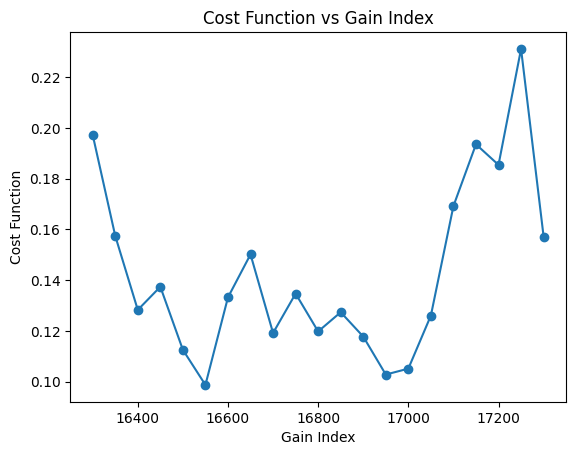

In [216]:
costs = [gain_index_to_cost[gain_index] for gain_index in gain_indices]

plt.plot(gains[gain_indices], costs, marker='o')
plt.xlabel('Gain Index')
plt.ylabel('Cost Function')
plt.title('Cost Function vs Gain Index')
plt.show()

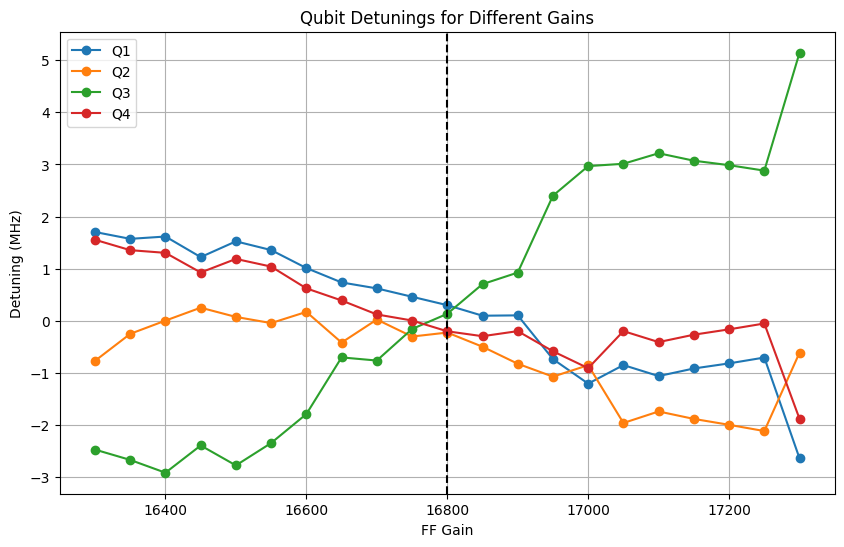

In [220]:
qubit_detunings = np.zeros((num_qubits, len(gain_indices)))

for i in range(len(gain_indices)):
    gain_index = gain_indices[i]
    simulation_params = default_params | gain_index_to_optimal_params[gain_index]

    for j in range(num_qubits):
        qubit_detunings[j, i] = simulation_params['initial_detunings'][j] / (2 * np.pi)  # convert to MHz


plt.figure(figsize=(10, 6))
for i in range(num_qubits):
    plt.plot(gains[gain_indices], qubit_detunings[i], marker='o', label=f'Q{i+1}')  

plt.axvline(16800, color='black', linestyle='--')

plt.xlabel('FF Gain')
plt.ylabel('Detuning (MHz)')
plt.title('Qubit Detunings for Different Gains')
plt.grid()
plt.legend()
plt.show()

In [ ]:
# # # sweep_qubit_to_data

# swept_qubit = 'Q3'
# sweep_qubit_to_data[swept_qubit] = {}
# sweep_qubit_to_data[swept_qubit]['cost'] = gain_index_to_cost[gain_index]
# sweep_qubit_to_data[swept_qubit]['gains'] = gains
# sweep_qubit_to_data[swept_qubit]['optimal_params'] = gain_index_to_optimal_params[gain_index]
# sweep_qubit_to_data[swept_qubit]['default_params'] = default_params



In [ ]:
# poster flow
# 1. prepare eigenstates of resonant lattice adiabatically
# 2. ues probe qubit to determine sign of coupling
# 3. another method to characterize any pair of adjacent qubits is to detune them from the lattice and measure swaps
#   a. can already measure populations
#   b. swaps tell us about the phase between the two qubits depending on the contrast
# 4. we can control 